In [1]:
import pandas as pd
import numpy as np
from pynm.pynm import PyNM
import matplotlib.pyplot as plt
import seaborn as sns
import patsy as pat
import statsmodels.api as sm

# **Getting Started**

In this tutorial we'll look at using the two simplest models LOESS & Centiles, with the same dataset from tutorial 0 to illustrate the advantage of normative modeling over case-control analysis.

## **Normative Modeling Basics**
The basic idea of normative modeling is to fit a model on the controls (or a subset of them) of a dataset, and apply it to the rest of the subjects. This trains the model on the normal range, and allows us to use it as a barometer of how far from that range new subjects are by comparing their actual score to what is expected by the model. We can use a variety of models for this task, but a key feature we want from our model is to estimate both the mean and the variance of the predictive distribution. The mean will give us a value to compare our subjects scores to, and the variance will allow us to quantify the normal range of deviations.

## **PyNM**
To get started using PyNM, all we need is a dataframe with the following columns:
- group
    - A column that indicates probands and controls
- score
    - The response variable of interest
- confound(s)
    - The explanatory variable(s)

## **Centiles & LOESS**
Both the Centiles & LOESS approaches operate by dividing the dataset into bins along the range of a single explanatory variable and estimating a simple model in each bin.
- Centiles fits a linear model in each bin.
- LOESS fits a polynomial model in each bin.

## **Example**
### Generate Data
Here we are using a dataset with:
- A single explanatory variable (age)
- Homoskedastic variance across the explanatory variable
- Gaussian noise
- A random offset in score for probands pulled from the gaussian distribution

In [2]:
# Define Functions
def sample_x(low=1,high=100,n_subs=1000,sampling='full'):
    if sampling =='full':
        x = np.random.uniform(low=low,high=high,size=n_subs)
    else:
        x = np.concatenate([np.random.normal(20,10,size=int(n_subs/2)),np.random.normal(80,10,size=int(n_subs/2))])
        x = x[(x<high) & (x > low)]
    return x

def proband(x):
    # Random increase in score
    return 2*np.log(x) + np.random.randn() + np.random.normal(0.7,1)

def control(x):
    return 2*np.log(x) + np.random.randn()

def dataset(seed=10,sampling='full'):
    # Set seed
    np.random.seed(seed)

    # Age param
    x = np.sort(sample_x(sampling=sampling))

    # PROB = 1/CTR = 0
    status1 =  np.random.binomial(1,0.2,size=(int(0.75*x.shape[0])))
    status2 =  np.random.binomial(1,0.07,size=(x.shape[0] - status1.shape[0]))
    status = np.concatenate([status1, status2])

    # Score param
    score = np.zeros(x.shape[0])
    for i in range(x.shape[0]):
        if status[i] == 1:
            score[i] = proband(x[i])
        else:
            score[i] = control(x[i])

    return pd.DataFrame([x,status,score],index=['age','status','score']).transpose()

In [3]:
# Create a dataset
df = dataset()
df.head()

,age,status,score
0,1.174205,0.0,1.733340
1,1.329895,1.0,0.420940
2,1.390878,0.0,0.903743
3,1.418167,0.0,2.137399
4,1.436357,0.0,-0.279385


### Visualize data
- CTR = 0
- PROB = 1

We can see below that extreme scores for a given age are more frequently probands.

<AxesSubplot:xlabel='age', ylabel='score'>

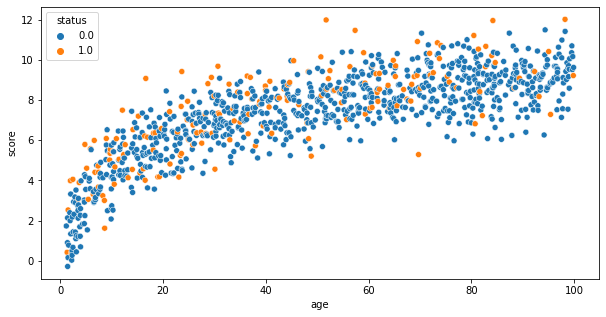

In [4]:
plt.figure(figsize=(10,5))
sns.scatterplot(x='age',y='score',hue='status',data=df)

### Fit Centiles & LOESS models with default parameters
First we initialize a PyNM object with our dataset, the columns that indicate the score and the group (PROB/CTR), and the confounds (explanatory variables). In this example we will only be using a single explanatory variable, but in later tutorials we will cover models that take an arbitrary number.

In [5]:
# Initialize pynm object w/ data and confound
m = PyNM(df,'score','status',['age'])

# Run models
m.loess_normative_model()
m.centiles_normative_model()

Models will be fit on full set of controls.


The default parameters for the LOESS and Centiles models give us a rough grained fit to our data by choosing a relatively large bin size and spacing, we can adjust that by specifying the bin size and width directly when we instantiate the PyNM object.

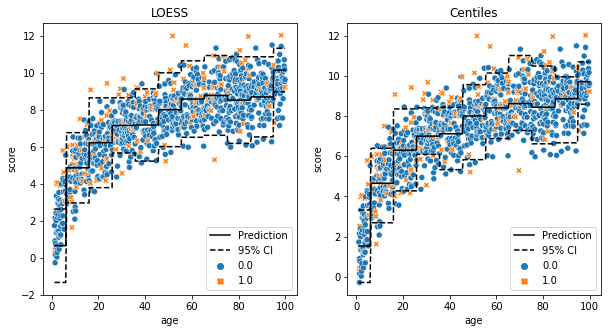

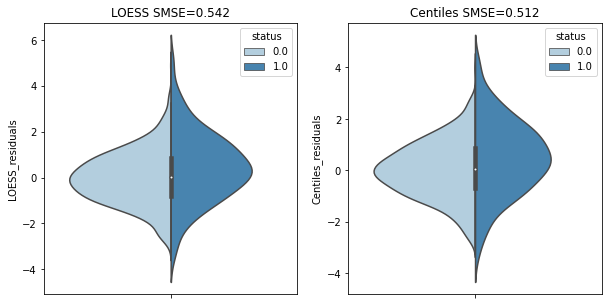

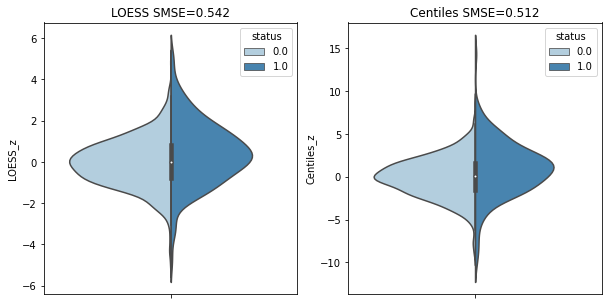

In [6]:
# Plot the data, model prediction, & 95% confidence interval
m.plot()

# Plot the residuals of the model (actual value - predicted value)
m.plot_res()

# Plot the z-scores of the model (model residuals / std deviation)
m.plot_z()

### Fit Centiles & LOESS models with custom bin parameters
Here we initialize a PyNM object in the same manner as before, but we specify the `bin_spacing` and `bin_width` parameters to get a finer grained fit to our data.

In [27]:
# Initialize pynm object w/ data and confound
m_fine = PyNM(df,'score','status',['age'],bin_spacing=1,bin_width=7)

# Run models
m_fine.loess_normative_model()
m_fine.centiles_normative_model()

Models will be fit on full set of controls.


We can see below that using finer values for `bin_spacing` and a larger `bin_width` gives us a smoother fit. Note that increasing the `bin_width` smooths the fit, but it can also include subjects in each bin that have very different scores and results in a less optimal local fit - this can be seen clearly in the younger age range with the centiles model.

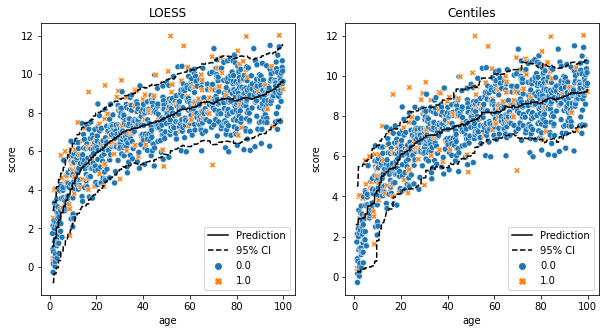

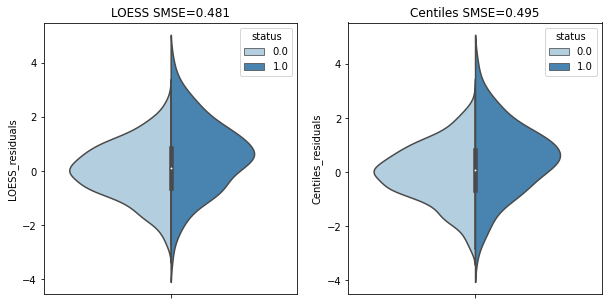

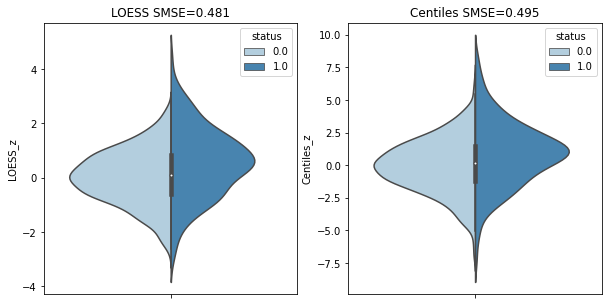

In [28]:
# Plot the data, model prediction, & 95% confidence interval
m_fine.plot()

# Plot the residuals of the model (actual value - predicted value)
m_fine.plot_res()

# Plot the z-scores of the model (model residuals / std deviation)
m_fine.plot_z()

### Fit Centiles & LOESS models with missing data
One of the main limitations of the Centiles & LOESS models is do not handle missing data well. If there is insufficient data in a bin the model won't be run there and we will have gaps in our results, and if there are simply very few data points in a bin the model estimates won't be reliable. We'll look at other models in the next tutorials that adress this limitation.

To illustrate this we'll generate the same dataset as above but with a gap in subjects for a given age, then fit the LOESS and Centiles models on it with different values of `bin_width` and `bin_spacing` to highlight both issues.

<AxesSubplot:xlabel='age', ylabel='score'>

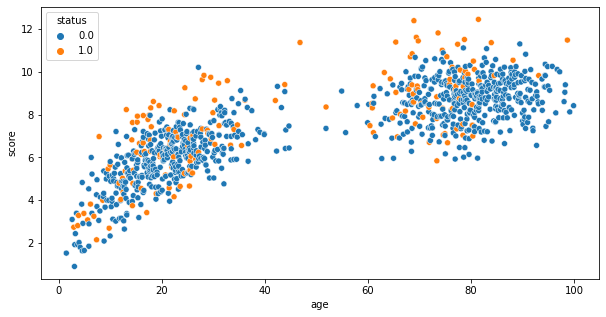

In [9]:
# Create a dataset
df_gap = dataset(sampling='gap')

# Visualize data
plt.figure(figsize=(10,5))
sns.scatterplot(x='age',y='score',hue='status',data=df_gap)

In [25]:
# Initialize pynm object w/ data and confound
m_gap1 = PyNM(df_gap,'score','status',['age'],bin_spacing=1,bin_width=7)
m_gap2 = PyNM(df_gap,'score','status',['age'],bin_spacing=1,bin_width=3)

# Run models
m_gap1.loess_normative_model()
m_gap1.centiles_normative_model()

m_gap2.loess_normative_model()
m_gap2.centiles_normative_model()

Models will be fit on full set of controls.
Models will be fit on full set of controls.


/home/harveyaa/Documents/masters/PyNM/pynm/pynm.py:412: RuntimeWarning: invalid value encountered in greater_equal
  result[else_mask] = np.array([np.argmin(self.data[self.score][i] >= centiles[i]) for i in range(self.data.shape[0])])[else_mask]


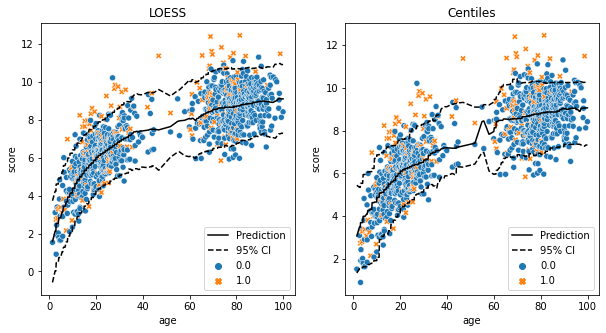

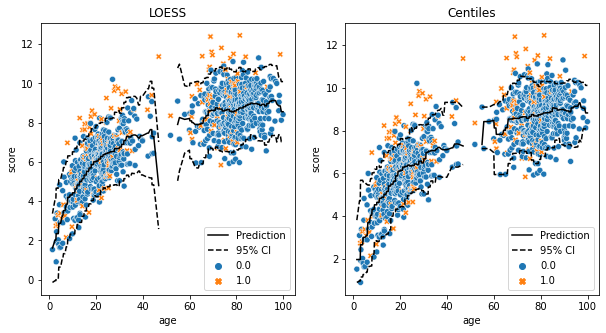

In [26]:
# Plot the data, model prediction, & 95% confidence interval
m_gap1.plot()
m_gap2.plot()

## **Case-control**
Finally, we'll return to our example from tutorial 0. As we saw before, a case-control on the raw scores returns no significant difference. However, when we use the deviance scores from the model the results are clearly significant - this indicates that the normative model captures information that the simple group average doesn't. Great news!

In [12]:
def case_control(df, group='status',score='score'):
    dmat = pat.dmatrix('C({})'.format(group), df, return_type='dataframe',NA_action='raise')
    results = sm.OLS(df[score],dmat).fit()
    return results.pvalues[1]

In [13]:
p_uncorrected = case_control(m_fine.data,score='score')
p_centiles = case_control(m_fine.data,score='Centiles_z')
p_loess = case_control(m_fine.data,score='LOESS_z')

print('Uncorrected: p =', p_uncorrected)
print('Centiles: p =', p_centiles)
print('LOESS: p =', p_loess)

Uncorrected: p = 0.9926933783317063
Centiles: p = 1.5113687460040483e-07
LOESS: p = 2.74013916875087e-09


## **Full LOESS & Centiles Outputs**
We can explore the full outputs of the LOESS & Centiles models by accessing the `data` attribute of the PyNM object. In general, all model outputs will be added as columns to the PyNM dataframe or as attributes to the PyNM object.

In [14]:
m_fine.data.head()

,age,status,score,LOESS_pred,LOESS_sigma,LOESS_residuals,LOESS_z,LOESS_rank,Centiles,Centiles_pred,Centiles_95,Centiles_5,Centiles_sigma,Centiles_residuals,Centiles_z,Centiles_rank
0,1.174205,0.0,1.733340,1.067869,0.957103,0.665471,0.695298,0.0,32.0,2.597343,4.522044,0.224568,0.68176,-0.864002,-1.267312,-2.0
1,1.329895,1.0,0.420940,1.067869,0.957103,-0.646929,-0.675925,0.0,8.0,2.597343,4.522044,0.224568,0.68176,-2.176403,-3.192332,-2.0
2,1.390878,0.0,0.903743,1.067869,0.957103,-0.164126,-0.171482,0.0,16.0,2.597343,4.522044,0.224568,0.68176,-1.693600,-2.484159,-2.0
3,1.418167,0.0,2.137399,1.067869,0.957103,1.069530,1.117466,1.0,39.0,2.597343,4.522044,0.224568,0.68176,-0.459944,-0.674643,-2.0
4,1.436357,0.0,-0.279385,1.067869,0.957103,-1.347254,-1.407637,-1.0,1.0,2.597343,4.522044,0.224568,0.68176,-2.876728,-4.219563,-2.0


### Description of columns
All values for the LOESS & Centiles models are from the bin whose center is closest to a given subject.
- age
    - From the input dataframe.
- status
    - From the input dataframe.
- score
    - From the input dataframe.
- LOESS_pred
    - Prediction of the LOESS model.
- LOESS_sigma
    - Standard deviation of the LOESS model.
- LOESS_residuals
    - Difference between actual value of score and LOESS_pred.
- LOESS_z
    - LOESS_residuals / LOESS_sigma.
- LOESS_rank
    - Rank of subject based on LOESS_z.
- Centiles
    - The centile of each subject's score.
- Centiles_pred
    - Prediction of the Centiles model (centile 50).
- Centiles_95
    - 95% confidence interval for the Centiles model (centile 95).
- Centiles_5
    - 5% confidence interval for the Centiles model (centile 95).
- Centiles_sigma
    - Standard deviation of the Centiles model, estimated as (centile 68 - centile 32)/2 which assumes gaussian noise.
- Centiles_residuals
    - Difference between actual value of score and Centiles_pred.
- Centiles_z
    - Centiles_residuals / Centiles_sigma
- Centiles_rank
    - Rank of subject based on Centiles_pred.

## **Summary**
- The basic format of normative modeling is to fit a model on the controls (or a subset of) and then predict using the rest of the dataset
- To use PyNM all we need is a dataframe with columns for group, score and confound(s)
- The LOESS & Centiles models work by splitting the dataset into bins and estimating a model in each
- We can adjust the model fit by changing the `bin_width` and `bin_spacing` parameters
- The LOESS & Centiles models do not handle missing data well
- Normative modeling captures information that case-control analysis doesn't
- We can access the full output of all the models using the `data` attribute of the PyNM object

## **Resources**
Example of use of the LOESS approach:
- Lefebvre et al. Front. Neurosci. 2018 [doi:10.3389/fnins.2018.00662](https://doi.org/10.3389/fnins.2018.00662)
- Maruani et al. Front. Psychiatry 2019 [doi:10.3389/fpsyt.2019.00011](https://doi.org/10.3389/fpsyt.2019.00011)

For the Centiles approach see:
- Bethlehem et al. Communications Biology 2020 [doi:10.1038/s42003-020-01212-9](https://doi.org/10.1038/s42003-020-01212-9)
- R implementation [here](https://github.com/rb643/Normative_modeling).

### **Next up:** Normative modeling with multivariate confounds using the Gaussian Process model!